<h1 style="color:#54a7b5">3D Computer Vision (WS25/26) - Project</h1>

<h2 style="color:#007b90">General Information</h2>

Upload: 29.10.2025

**Intermediate Deadline**: 27.11.2025 (Step 1-2)

**Final Deadline**: 23.01.2026 (Step 1-5)

<h3 style="color:#003476">Your Group</h3>

Submitted by Group XX: 
- Aishwaryaraj Chandel
- Shivam singh
- Paula Nebgen

<h3 style="color:#003476">Submission</h3>

Please hand in a single **.zip** file named according to the pattern "**groupXX**" (e.g. group00). The contents of the .zip should be as follows:
- folder with the same name as the **.zip** file
    - **.ipynb** file
    - **.html** export of .ipynb with all the outputs you got
    - **data** folder containing necessary files to run the code

By submitting this exercise, you confirm the following:
- **All people** listed above **contributed** to this solution
- **No other people** were **involved** in this solution
- **No contents** of this solution were **copied from others** (this includes people, large language models, websites, etc.)

<h3 style="color:#003476">Final Presentation</h3>

You will be required to present your solution in a 20 minute presentation, which includes:
- Problem Overview
- Solution Overview (e.g. pseudo code, mathematical formulas, visualizations)
- Describe challenges & optimizations

After the presentation, there will be 10 minutes of questions and answers about your work.


<h2 style="color:#007b90">3D Scene Reconstruction - Task Overview</h2>

Your task in this exercise is to do a dense reconstruction of a scene. This will involve multiple steps that you will encounter and learn about as the semester progresses. You can start implementing individual steps as soon as you learn about them or wait until you have learned more to implement everything together. In the latter case, be mindful that this exercise is designed for an entire semester and the workload is accordingly large.

<h3 style="color:#003476">Given Data</h3>

You will be given the following data:
- **9 color images** of the scene.
    - 8 Bit RGB per pixel.
    - Each image rendered from a different position.
    - The camera used had **lens distortion**.
- **9 Depth images** of the scene.
    - 8 Bit Grayscale per pixel. The result of dividing the Z-depth by **each image's maximum** and then multiplying by 255.
    - Each image has the **same pose** as the corresponding RGB image.
    - The camera used was **free of any distortions**.
- 1 Dictionary containing **camera calibration parameters**.
    - They belong to the camera that was used to render the RGB images.
    - Distortion coefficients are given in the standard [k<sub>1</sub>, k<sub>2</sub>, p<sub>1</sub>, p<sub>2</sub>, k<sub>3</sub>] order.
- 1 Numpy array containing **8 camera transformations**.
    - They specify the **movements** that the **camera went through** to render all images.
    - I.e. idx **0** specifies the transformation from **00.png to 01.png**, idx **1** specifies the transformation from **01.png to 02.png**, ...
    - This applies to both RGB and Depth images, as they have the same poses.
- 1 Numpy array containing **7 features**.
    - The features are specified for each of the 9 images.
    - Each feature is a **2D pixel location in "H, W" order**, meaning the first value is the height/row in the image and the second width/column.
    - If a feature was not visible, it was entered as [-1, -1].
    - The features are **unsorted**, meaning that feature idx 0 for 00.png could be corresponding to e.g. feature idx 4 for 01.png.

<h3 style="color:#003476">Solution Requirements</h3>

- Your code needs to **compile**, **run**, and produce an **output**.
- Your target output should be a **dense point cloud** reconstruction (without holes) of the scene.
    - The output should be in the **.ply format**. We provide a function that can exports a .ply file.
    - You may inspect your .ply outputs in e.g. **Meshlab**.
    - See the 'Dense Point Cloud' sample image to get an idea of what is possible. (Meshlab screenshot with point shading set to None; see example under data/samples)
- Your code should be a **general solution**.
    - This means that it could run correctly for a different dataset (with same input structure).
    - It should **NOT** include anything **hardcoded** specific to this dataset.
- Your code should not be unnecessarily inefficient.
    - Our sample solution runs in less than 2 minutes total (including point cloud export).
    - If your solution runs for more than 10 minutes, you are being wasteful in some part of your program.

<h2 style="color:#007b90">Imports</h2>

Please note the following:
- These are all imports necessary to achieve the sample results.
- You may remove and/or add other libraries at your own convinience.
- Using library functions (from the given or other libraries) that bypass **necessary computer vision tasks** will not be recognized as 'solved'.
    - E.g.: If you **need** to undistort an image to **get to the next step** of the solution and use the library function cv2.undistort(), then we will evaluate the **undistortion step** as '**failed**'.
    - E.g.: If you **want** to draw points in an image (to **check your method** or **visualize in-between steps**) and use the library function cv2.circle(), then there is **no problem**.
    - E.g.: If you **need** to perform complex **mathematical** operations and use some numpy function, then there is **no problem**.
    - E.g.: You do not like a **provided utility function** and find/know a library function that gives the **same outputs** from the **same inputs**, then there is **no problem**.

In [1]:
# Install the required packages
!pip install ipympl

# For JupyterLab, also install the extension
!jupyter labextension install @jupyter-widgets/jupyterlab-manager jupyter-matplotlib

# Or if using JupyterLab 3+
!jupyter labextension install @jupyter-widgets/jupyterlab-manager
!pip install ipympl

(Deprecated) Installing extensions with the jupyter labextension install command is now deprecated and will be removed in a future major version of JupyterLab.

Users should manage prebuilt extensions with package managers like pip and conda, and extension authors are encouraged to distribute their extensions as prebuilt packages 
/Users/Aishwaryaraj/Downloads/ENTER/lib/python3.13/site-packages/jupyterlab/debuglog.py:54: UserWarning: An error occurred.
  warnings.warn("An error occurred.")
/Users/Aishwaryaraj/Downloads/ENTER/lib/python3.13/site-packages/jupyterlab/debuglog.py:55: UserWarning: ValueError: Please install Node.js and npm before continuing installation. You may be able to install Node.js from your package manager, from conda, or directly from the Node.js website (https://nodejs.org).
  warnings.warn(msg[-1].strip())
/Users/Aishwaryaraj/Downloads/ENTER/lib/python3.13/site-packages/jupyterlab/debuglog.py:56: UserWarning: See the log file for details: /var/folders/2f/9svfc8fn

In [2]:
import os
import torch
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
#make plots interactive:
%matplotlib inline


<h2 style="color:#007b90">Data Preparation</h2>

In [3]:
#Inputs
base_path = os.getcwd()
data_path = os.path.join(base_path, f"data")
img_path = os.path.join(data_path, 'images')
depth_path = os.path.join(data_path, 'depths')
print(f"The project's root path is '{base_path}'.")
print(f"Reading data from '{data_path}'.")
print(f"Image folder: '{img_path}'.")
print(f"Depth folder: '{depth_path}'.")

#Outputs
out_path = os.path.join(base_path, 'output')
ply_path = os.path.join(out_path, 'point_cloud')
os.makedirs(out_path, exist_ok=True)
os.makedirs(ply_path, exist_ok=True)
print(f"\nCreating directory '{out_path}'.")
print(f"Creating directory '{ply_path}'.")

#Load Data
camera_calibration = np.load(os.path.join(data_path, 'camera_calibration.npy'), allow_pickle=True)
camera_calibration = camera_calibration.item()#get dictionary from numpy array struct
given_features = np.load(os.path.join(data_path, 'given_features.npy'), allow_pickle=True)
camera_movement = np.load(os.path.join(data_path, 'camera_movement.npy'), allow_pickle=True)

print(f"\nCamera Calibration:")
for entry in camera_calibration.items():
    print(f"  {entry[0]}: {entry[1]}")
print(f"Camera Movement: {camera_movement.shape}")#[Cameras-1, 4, 4]
print(f"2D Features (Unsorted): {given_features.shape}")#[Camera_idx, Feature_idx, 2]

The project's root path is '/Users/Aishwaryaraj/Documents/RPTU Course Assignment Projects/3D Computer Vision/3D-Scene-Reconstruction/Project_Grp_13'.
Reading data from '/Users/Aishwaryaraj/Documents/RPTU Course Assignment Projects/3D Computer Vision/3D-Scene-Reconstruction/Project_Grp_13/data'.
Image folder: '/Users/Aishwaryaraj/Documents/RPTU Course Assignment Projects/3D Computer Vision/3D-Scene-Reconstruction/Project_Grp_13/data/images'.
Depth folder: '/Users/Aishwaryaraj/Documents/RPTU Course Assignment Projects/3D Computer Vision/3D-Scene-Reconstruction/Project_Grp_13/data/depths'.

Creating directory '/Users/Aishwaryaraj/Documents/RPTU Course Assignment Projects/3D Computer Vision/3D-Scene-Reconstruction/Project_Grp_13/output'.
Creating directory '/Users/Aishwaryaraj/Documents/RPTU Course Assignment Projects/3D Computer Vision/3D-Scene-Reconstruction/Project_Grp_13/output/point_cloud'.

Camera Calibration:
  distortion_param: [-0.1, 0.02, 0.0, 0.0, -0.01]
  image_height: 551
  im

<h2 style="color:#007b90">Provided Utility Functions</h2>

These functions are provided to reduce the complexity of some steps you might encounter. They were involved in the creation of the given samples. However, you do not have to use them and can use other means of achieving the same results.

In [4]:
def sample_image(numpy_image, numpy_sample_grid):
    '''
    This function samples a target image from a source image (numpy_image) based on specified pixel coordinates (numpy_sample_grid).
    Inputs:
        numpy_image: of shape=[H, W, C]. H is the height, W is the width, and C is the color channel of the source image from which color values will be sampled.
        numpy_sample_grid: of shape=[H, W, UV]. H is the height and W is the width of the target image that will be sampled. UV are the pixel locations in the source image from which to sample color values.
    Outputs:
        sampled_image: of shape=[H, W, C]. H is the height, W is the width, and C is the color channel of the target image that was sampled.
    
    The following is a simple toy example to see the behavior of the sample_image function

    example_source = (np.random.rand(110, 220, 3)*255).astype(int) #[110, 220, 3]
    example_grid = np.ones([100, 200, 2]) #[100, 200, 2]
    example_grid[:, :, 1] = 2
    example_target = sample_image(example_source, example_grid) #[100, 200, 3]

    example_target will be of shape [100, 200, 3]
    -> 100, because example_grid has a height of 100
    -> 200, because example_grid has a width of 200
    -> 3, because example_source has a color channel of 3
    print(example_source.shape)

    example_target will contain the value of example_source[2, 1] at every pixel
    -> 2, because example_grid[:, :, 1] has a value of 2 for every pixel
    -> 1, because example_grid[:, :, 0] has a value of 1 for every pixel
    print(example_source[2, 1, 0], "->", np.unique(example_target[:, :, 0]))
    print(example_source[2, 1, 1], "->", np.unique(example_target[:, :, 1]))
    print(example_source[2, 1, 2], "->", np.unique(example_target[:, :, 2]))
    
    '''
    height, width, _ = numpy_image.shape#[H, W, 3]

    #turn numpy array to torch tensor
    torch_sample_grid = torch.from_numpy(numpy_sample_grid)#[H, W, 2]
    #normalize from range (0, width-1) to (0, 1)
    torch_sample_grid[:, :, 0] = torch_sample_grid[:, :, 0] / (width-1)
    #normalize from range (0, height-1) to (0, 1)
    torch_sample_grid[:, :, 1] = torch_sample_grid[:, :, 1] / (height-1)
    #normalize from range (0, 1) to (-1, 1)
    torch_sample_grid = torch_sample_grid*2 -1

    #transform to necessary shapes
    torch_sample_grid = torch_sample_grid.unsqueeze(0)#[1, H, W, 2]
    torch_image = torch.from_numpy(numpy_image).double().permute(2, 0, 1).unsqueeze(0)#[1, 3, H, W]
    #sample image according to sample grid locations from source image
    sampled_image = torch.nn.functional.grid_sample(torch_image, torch_sample_grid, mode='bilinear', padding_mode='zeros', align_corners=True)
    #transform back to numpy image
    sampled_image = sampled_image.squeeze().permute(1, 2, 0).numpy().astype(np.uint8)#[H, W, 3]
    return sampled_image

def ply_creator(input_3d, rgb_data=None, filename='dummy'):
    ''' Creates a colored point cloud that you can visualise using e.g. Meshlab.
    Inputs:
        input_3d: of shape=[N, 3], each row is the 3D coordinate of each point
        rgb_data(optional): of shape=[N, 3], each row is the rgb color value of each point
        filename: file name for the .ply file to be created 
    '''
    assert (input_3d.ndim==2),"Pass 3d points as NumPointsX3 array "
    pre_text1 = """ply\nformat ascii 1.0"""
    pre_text2 = "element vertex "
    pre_text3 = """property float x\nproperty float y\nproperty float z\nproperty uchar red\nproperty uchar green\nproperty uchar blue\nend_header"""
    pre_text22 = pre_text2 + str(input_3d.shape[0])
    pre_text11 = pre_text1
    pre_text33 = pre_text3
    filename = filename + '.ply'
    fid = open(filename, 'w')
    fid.write(pre_text11)
    fid.write('\n')
    fid.write(pre_text22)
    fid.write('\n')
    fid.write(pre_text33)
    fid.write('\n')
    for i in range(input_3d.shape[0]):
        for c in range(3):
            fid.write(str(input_3d[i,c]) + ' ')
        if not rgb_data is None:
            for c in range(3):
                fid.write(str(rgb_data[i,c]) + ' ')
        if i!=input_3d.shape[0]:
            fid.write('\n')
    fid.close()
    return filename 

<h2 style="color:#007b90">Step 1: Undistortion of the RGB Images</h2>

As described in the Given Data section, the RGB images contain lens distortion, while the depth images are already undistorted. To ensure accurate 3D reconstruction, the two modalities must be aligned.

Undistort all RGB images, then visualize one example image before and after undistortion.

Camera Matrix K:
[[629.28571429   0.         440.        ]
 [  0.         629.28571429 275.        ]
 [  0.           0.           1.        ]]

Inverse Camera Matrix K_inv:
[[ 0.0015891   0.         -0.69920545]
 [ 0.          0.0015891  -0.43700341]
 [ 0.          0.          1.        ]]

Distortion Coefficients [k1, k2, p1, p2, k3]:
[-0.1   0.02  0.    0.   -0.01]

Undistorting images...
  Undistorted 00.png
  Undistorted 01.png
  Undistorted 02.png
  Undistorted 03.png
  Undistorted 04.png
  Undistorted 05.png
  Undistorted 06.png
  Undistorted 07.png
  Undistorted 08.png


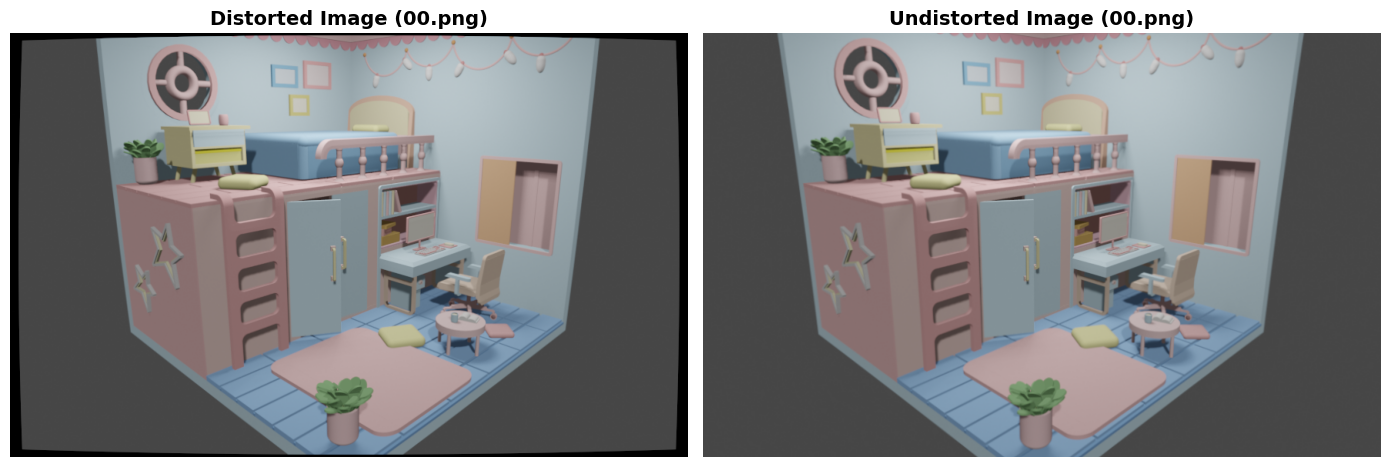


Total images undistorted: 9
Undistorted images are stored in 'undistorted_images' list

Undistortion complete! The distortion model applied:
  x_distorted = x_normalized * (1 + k1*r² + k2*r⁴ + k3*r⁶) + tangential_x
  y_distorted = y_normalized * (1 + k1*r² + k2*r⁴ + k3*r⁶) + tangential_y


In [5]:
# Step 1: Undistortion of RGB Images using Homogeneous Coordinates

import os
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

# Load camera calibration parameters
data_path = 'data'
camera_calibration = np.load(os.path.join(data_path, 'camera_calibration.npy'), allow_pickle=True).item()

# Extract calibration parameters
img_height = camera_calibration['image_height']
img_width = camera_calibration['image_width']
focal_length_px = camera_calibration['focal_length_px']
principal_point = camera_calibration['principal_point']  # [cy, cx] in H,W order
distortion_coeffs = np.array(camera_calibration['distortion_param'])

# Build camera matrix K
cx = principal_point[1]  # column (width)
cy = principal_point[0]  # row (height)

K = np.array([
    [focal_length_px, 0, cx],
    [0, focal_length_px, cy],
    [0, 0, 1]
], dtype=np.float64)

K_inv = np.linalg.inv(K)

print("Camera Matrix K:")
print(K)
print("\nInverse Camera Matrix K_inv:")
print(K_inv)
print("\nDistortion Coefficients [k1, k2, p1, p2, k3]:")
print(distortion_coeffs)

# Extract distortion coefficients
k1, k2, p1, p2, k3 = distortion_coeffs

def undistort_image_homogeneous(distorted_img, K, K_inv, k1, k2, p1, p2, k3):
    """
    Undistort image using homogeneous coordinates and manual distortion correction.
    
    Process:
    1. For each pixel in the undistorted (output) image
    2. Convert to normalized camera coordinates using K_inv
    3. Apply distortion model to find corresponding distorted coordinates
    4. Convert back to pixel coordinates using K
    5. Sample from the distorted image at those coordinates
    """
    h, w = distorted_img.shape[:2]
    
    # Create mesh grid of pixel coordinates for undistorted image
    u_undist, v_undist = np.meshgrid(np.arange(w), np.arange(h))
    
    # Convert to homogeneous coordinates [u, v, 1]
    coords_homogeneous = np.stack([
        u_undist.flatten(),
        v_undist.flatten(),
        np.ones(u_undist.size)
    ], axis=0)  # Shape: [3, H*W]
    
    # Transform to normalized camera coordinates: [x_n, y_n, 1]
    normalized_coords = K_inv @ coords_homogeneous  # [3, H*W]
    x_n = normalized_coords[0, :]  # normalized x coordinates
    y_n = normalized_coords[1, :]  # normalized y coordinates
    
    # Apply distortion model
    # Compute radial distance squared
    r2 = x_n**2 + y_n**2
    r4 = r2**2
    r6 = r2**3
    
    # Radial distortion factor
    radial_distortion = 1 + k1*r2 + k2*r4 + k3*r6
    
    # Tangential distortion
    tangential_x = 2*p1*x_n*y_n + p2*(r2 + 2*x_n**2)
    tangential_y = p1*(r2 + 2*y_n**2) + 2*p2*x_n*y_n
    
    # Apply distortion: distorted = undistorted * radial + tangential
    x_d = x_n * radial_distortion + tangential_x
    y_d = y_n * radial_distortion + tangential_y
    
    # Convert distorted normalized coordinates back to homogeneous
    distorted_normalized = np.stack([x_d, y_d, np.ones_like(x_d)], axis=0)  # [3, H*W]
    
    # Project back to pixel coordinates
    distorted_pixels = K @ distorted_normalized  # [3, H*W]
    u_dist = distorted_pixels[0, :]
    v_dist = distorted_pixels[1, :]
    
    # Reshape to image dimensions
    u_dist = u_dist.reshape(h, w)
    v_dist = v_dist.reshape(h, w)
    
    # Create sampling grid [H, W, 2] where last dimension is [u, v]
    sample_grid = np.stack([u_dist, v_dist], axis=-1)
    
    # Use the provided sample_image function or implement bilinear interpolation
    # Here we'll use cv2.remap for efficiency
    map_x = sample_grid[:, :, 0].astype(np.float32)
    map_y = sample_grid[:, :, 1].astype(np.float32)
    
    undistorted_img = cv.remap(distorted_img, map_x, map_y, 
                                cv.INTER_LINEAR, borderMode=cv.BORDER_CONSTANT)
    
    return undistorted_img

# Load and undistort all RGB images
img_path = os.path.join(data_path, 'images')
img_files = sorted([f for f in os.listdir(img_path) if f.endswith('.png')])

undistorted_images = []

print("\nUndistorting images...")
for img_file in img_files:
    # Load distorted image
    distorted_img = cv.imread(os.path.join(img_path, img_file))
    
    # Undistort using homogeneous coordinates
    undistorted_img = undistort_image_homogeneous(
        distorted_img, K, K_inv, k1, k2, p1, p2, k3
    )
    
    undistorted_images.append(undistorted_img)
    print(f"  Undistorted {img_file}")

# Visualize one example (first image)
example_idx = 0
distorted_example = cv.imread(os.path.join(img_path, img_files[example_idx]))
undistorted_example = undistorted_images[example_idx]

# Create visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

axes[0].imshow(cv.cvtColor(distorted_example, cv.COLOR_BGR2RGB))
axes[0].set_title('Distorted Image (00.png)', fontsize=14, fontweight='bold')
axes[0].axis('off')
axes[0].grid(True, alpha=0.3)

axes[1].imshow(cv.cvtColor(undistorted_example, cv.COLOR_BGR2RGB))
axes[1].set_title('Undistorted Image (00.png)', fontsize=14, fontweight='bold')
axes[1].axis('off')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nTotal images undistorted: {len(undistorted_images)}")
print("Undistorted images are stored in 'undistorted_images' list")
print("\nUndistortion complete! The distortion model applied:")
print("  x_distorted = x_normalized * (1 + k1*r² + k2*r⁴ + k3*r⁶) + tangential_x")
print("  y_distorted = y_normalized * (1 + k1*r² + k2*r⁴ + k3*r⁶) + tangential_y")

Example visualization

![title](data/samples/image_distortion.png)

<h2 style="color:#007b90">Step 2: Common Camera Reference Frame</h2>

The provided camera poses are expressed relative to consecutive frames (e.g. the first pose is a transformation from the first view to the second view). However, the final point cloud needs to be definied with respect to a single, common world coordinate system.

Compute camera poses such that they are expressed in terms of a shared world reference frame, and then visualize all camera positions and orientations in a single 3D plot.


 STEP 2:
Computed 9 camera poses in world frame.
First camera pose (identity):
[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]
Second camera pose:
[[ 0.70710678 -0.1830127   0.6830127  -3.        ]
 [ 0.1830127   0.98037987  0.0732233  -0.25881905]
 [-0.6830127   0.0732233   0.72672691  0.96592583]
 [ 0.          0.          0.          1.        ]]


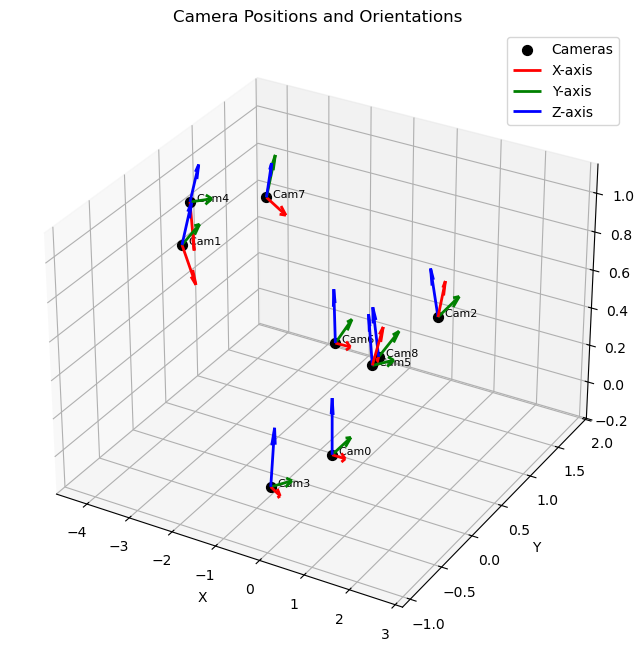

In [6]:
def compute_world_camera_poses(camera_movement):
    num_cameras = len(camera_movement) + 1
    world_poses = np.zeros((num_cameras, 4, 4))
    
    # First camera is the world reference frame (identity)
    world_poses[0] = np.eye(4)
    
    for i in range(1, num_cameras):
        # Multiply previous world pose with the relative transformation
        world_poses[i] = world_poses[i-1] @ camera_movement[i-1]
    return world_poses


def visualize_cameras(world_poses, scale=0.5):
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    colors = ['r', 'g', 'b']  # X, Y, Z axes colors
    axis_labels = ['X', 'Y', 'Z']
    
    for i, pose in enumerate(world_poses):
        # Extract camera position (translation)
        position = pose[:3, 3]
        
        # Extract rotation matrix
        rotation = pose[:3, :3]
        
        # Plot camera position
        ax.scatter(position[0], position[1], position[2], c='k', marker='o', s=50)
        ax.text(position[0], position[1], position[2], f'  Cam{i}', fontsize=8)
        
        # Plot camera orientation (coordinate axes)
        for j in range(3):
            axis_direction = rotation[:, j] * scale
            ax.quiver(position[0], position[1], position[2],
                     axis_direction[0], axis_direction[1], axis_direction[2],
                     color=colors[j], arrow_length_ratio=0.3, linewidth=2)
    
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title('Camera Positions and Orientations')
    ax.legend(['Cameras', 'X-axis', 'Y-axis', 'Z-axis'])
    plt.show()



print("\n STEP 2:")
WORLD_CAMERA_POSES = compute_world_camera_poses(camera_movement)
print(f"Computed {len(WORLD_CAMERA_POSES)} camera poses in world frame.")
print(f"First camera pose (identity):\n{WORLD_CAMERA_POSES[0]}")
print(f"Second camera pose:\n{WORLD_CAMERA_POSES[1]}")

visualize_cameras(WORLD_CAMERA_POSES, scale=0.3)

Example visualization

![title](data/samples/cameras.png)

<h2 style="color:#007b90">Step 3: Feature Matching and Depth Map Scaling</h2>

Each depth map is scaled differently according to its own maximum value. To obtain a consistent dense point cloud, we must correct these scalings so that 3D points from different views align properly.

Perform feature matching across the images, and use the corresponding matches to determine the correct scale factors for the depth maps.
Additionally, visualize one selected feature across all views.

In [7]:
# Updated loading logic for Step 3/4
def load_depth_only(depth_path):
    files = sorted([f for f in os.listdir(depth_path) if f.lower().endswith('.png')])
    depth_images = []
    for f in files:
        # Depth images are usually 16-bit or 8-bit; IMREAD_UNCHANGED preserves this
        d = cv.imread(os.path.join(depth_path, f), cv.IMREAD_UNCHANGED)
        depth_images.append(d)
    return depth_images

# depth_path was already defined as data_path/depths
DEPTH_IMGS = load_depth_only(depth_path)
print(f"Successfully loaded {len(DEPTH_IMGS)} depth maps.")

def get_F_matrix(K, R, t):
    t_skew = np.array([[0, -t[2], t[1]], [t[2], 0, -t[0]], [-t[1], t[0], 0]])
    E = t_skew @ R
    F = np.linalg.inv(K).T @ E @ np.linalg.inv(K)
    return F

# Intrinsic matrix from your helper
K_mat = get_K(camera_calibration)

# Store matched indices: sorted_indices[img_idx] gives the matching order
sorted_matches = []

for i in range(len(DEPTH_IMGS) - 1):
    T = camera_movement[i]
    R, t = T[:3, :3], T[:3, 3]
    F = get_F_matrix(K_mat, R, t)
    
    # Feature matching by minimizing distance to epipolar line
    match_map = []
    for feat_a in given_features[i]:
        p1 = np.array([feat_a[1], feat_a[0], 1.0])
        line_in_b = F @ p1
        
        dists = []
        for feat_b in given_features[i+1]:
            p2 = np.array([feat_b[1], feat_b[0], 1.0])
            d = abs(np.dot(p2, line_in_b)) / np.sqrt(line_in_b[0]**2 + line_in_b[1]**2)
            dists.append(d)
        match_map.append(np.argmin(dists))
    sorted_matches.append(match_map)

print("Epipolar matching complete for all 7 features.")


z_max_scales = [[] for _ in range(len(DEPTH_IMGS))]

for i in range(len(sorted_matches)):
    T = camera_movement[i]
    R, t = T[:3, :3], T[:3, 3]
    
    # Triangulate the 7 features
    P1 = K_mat @ np.eye(3, 4)
    P2 = K_mat @ np.hstack((R, t.reshape(3, 1)))
    
    # Reshape points for OpenCV
    pts1 = np.array([[f[1], f[0]] for f in given_features[i]]).T
    # Use the matches to align pts2 with pts1
    pts2 = np.array([[given_features[i+1][m][1], given_features[i+1][m][0]] for m in sorted_matches[i]]).T
    
    pts4D = cv.triangulatePoints(P1, P2, pts1, pts2)
    pts3D = pts4D[:3, :] / pts4D[3, :]
    
    # Calculate scale factor for each matched feature
    for j in range(len(given_features[i])):
        h, w = int(given_features[i][j][0]), int(given_features[i][j][1])
        raw_val = DEPTH_IMGS[i][h, w]
        if raw_val > 0:
            # Z_metric = (raw_val / 255) * Z_max  => Z_max = (Z_metric * 255) / raw_val
            z_max_scales[i].append(pts3D[2, j] * 255.0 / raw_val)

# Take median scale per image
final_scales = [np.median(s) if s else 1.0 for s in z_max_scales]
print(f"{'Images'} | {'Scale Value'}")
for i,s in enumerate(final_scales):
    clean_val = abs(float(s))
    print(f"Img {i:02d} | {clean_val:.3f}")

# -------------------------------------------------------------------
# 3.1) Feature Matching (Sorting the 7 features using Epipolar Geometry)
# -------------------------------------------------------------------
# matches_sequence[i][j] = k means feature j in image i matches feature k in image i+1
# Track the 0th feature from the first image
current_idx = 0
tracking = [current_idx]
for i in range(len(sorted_matches)):
    current_idx = sorted_matches[i][current_idx]
    tracking.append(current_idx)

fig, axes = plt.subplots(3, 3, figsize=(15, 12))
axes = axes.flatten()

step3_out_path = os.path.join(out_path, "step 3 output")
os.makedirs(step3_out_path, exist_ok=True)
for i in range(len(UNDISTORTED_RGB_IMGS)):
    img= UNDISTORTED_RGB_IMGS[i].copy()
    img_draw = UNDISTORTED_RGB_IMGS[i].copy()
    img_bgr = cv.cvtColor(img_draw, cv.COLOR_RGB2BGR)
    feat_idx= tracking[i]
    h,w= given_features[i][feat_idx]
    
    cv.circle(img, (int(w), int(h)), 15, (0, 255, 0), -1)
    save_file = os.path.join(step3_out_path, f"tracked_view_{i:02d}.png")
    cv.imwrite(save_file, img_bgr)
    axes[i].imshow(img)
    axes[i].axis('off')

plt.tight_layout()
plt.show()

Successfully loaded 9 depth maps.


NameError: name 'get_K' is not defined

Example visualization of the 7 features

![title](data/samples/00_features.png)

<h2 style="color:#007b90">Step 4: Depth Map to 3D Points</h2>

Using the rescaled depth maps together with the camera poses from Step 2, compute the 3D coordinates for all pixel in each RGB image.

In [ ]:
# Include the necessary code here
global_scale = np.median([abs(float(s)) for s in final_scales])
print(f"Using Global Scale Factor: {global_scale:.4f}")
# 1. Prepare for 3D Projection
K_inv = np.linalg.inv(K_mat)
all_world_points = []
all_world_colors = []

# Assuming WORLD_CAMERA_POSES are the absolute poses in world frame [I | 0] for first cam
# and human_friendly_scales contains the Z_max for each view.

print("Projecting depth maps to 3D world points...")

for i in range(len(DEPTH_IMGS)):
    depth_map = DEPTH_IMGS[i]
    rgb_img = UNDISTORTED_RGB_IMGS[i]
    pose = WORLD_CAMERA_POSES[i] # 4x4 Matrix [R | t ; 0 | 1]
    
    mask = (depth_map > 10) & (depth_map < 245)
    
    # Get pixel coordinates
    h, w = depth_map.shape
    v, u = np.where(mask) # v=row(y), u=col(x)
    
    # Metric Depth
    z = (depth_map[mask] / 255.0) * global_scale
    
    # 3. BACK-PROJECTION
    # Local Camera Space
    p_hom = np.stack([u, v, np.ones_like(u)], axis=0)
    p_cam = (K_inv @ p_hom) * z
    
    # 4. WORLD TRANSFORMATION
    R = pose[:3, :3]
    t = pose[:3, 3].reshape(3, 1)
    p_world = (R @ p_cam) + t
    
    all_world_points.append(p_world.T)
    all_world_colors.append(rgb_img[mask])
    
    print(f"View {i:02d}: Generated {points_world.shape[0]} 3D points.")

def visualize_step4(idx, world_poses, all_points, all_colors, axis_scale=0.5, point_subsample=20):
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection='3d')
    
    # --- 1. Plot All Cameras (Reference Code Logic) ---
    axis_colors = ['r', 'g', 'b']
    for i, pose in enumerate(world_poses):
        position = pose[:3, 3]
        rotation = pose[:3, :3]
        
        # Camera center
        ax.scatter(position[0], position[1], position[2], c='k', marker='o', s=30)
        
        # Camera axes (Quivers)
        for j in range(3):
            direction = rotation[:, j] * axis_scale
            ax.quiver(position[0], position[1], position[2],
                     direction[0], direction[1], direction[2],
                     color=axis_colors[j], linewidth=1)
            
        ax.text(position[0], position[1], position[2], f'Cam{i}', fontsize=8)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    
    # Adjust view to see the relationship between camera and points
    # Typically, points should appear in front of the Z-axis (Blue arrow) of the camera
    ax.view_init(elev=-50, azim=-100)
    
    plt.show()

# --- Usage ---
# idx: image index you want to see the points for
# world_poses: WORLD_CAMERA_POSES from Step 2
# all_points: the list of 3D point arrays generated in Step 4
# all_colors: the list of RGB color arrays generated in Step 4
visualize_step4(idx=0, 
                world_poses=WORLD_CAMERA_POSES, 
                all_points=all_world_points, 
                all_colors=all_world_colors)


Example visualization of cameras and 3D points (of the 7 features) from one image

![title](data/samples/features.png)

<h2 style="color:#007b90">Step 5: 3D Points to Point Cloud</h2>

Finally, use the provided `ply_creator` function to generate a merged colored point cloud from the computed 3D points from all images. Visualize the resulting point cloud in a viewer such as MeshLab.

In [ ]:
# Include the necessary code here

# 1. Combine all points and colors from all views
# These were the lists created in the Step 4 loop
dense_points_final = np.vstack(all_world_points)
dense_colors_final = np.vstack(all_world_colors)

# 2. Define the output filename and path
# Using the ply_path created in your Step 1
ply_filename = os.path.join(ply_path, 'merged_reconstruction')

print(f"Creating PLY file with {dense_points_final.shape[0]} points...")

# 3. Call the provided ply_creator function
# Note: ply_creator adds the '.ply' extension automatically
created_file = ply_creator(dense_points_final, 
                           rgb_data=dense_colors_final, 
                           filename=ply_filename)

print(f"saved point cloud on: {created_file}")


Example visualization

![title](data/samples/dense_point_cloud.png)